# Bluesky Data Collection Framework

Callum Forrester

## Bluesky

- Family of software libraries developed by NSLS-II in Brookhaven, New York, USA.
- Confusingly, also the name of one of those libraries!
- Analysis-first data collection
- Aimed at making it easy to programatically make a beamline produce diverse data/metadata to suit diverse analysis needs

<img src="img/logo-bluesky.png" width="500"/>

## NSLS-II
- Operational since 2015
- Storage ring nearly 800m in circumference

<img src="img/nsls2.png" width="500"/>

## Diamond Almost Fits Inside...

<img src="img/nsls2-dls.png" width="500"/>

## Bread & Butter of Data Collection

- Control environment with actuators, record data with sensors/detectors
- Classic example, move sample through beam with motors, take pictures of interfered beam with detector:

<img src="img/scanning.svg" width="1000"/>
<img src="img/graph.svg" width="500"/>

## Beamline Software Stack

<img src="img/stack.svg" width="500"/>

## A Good DCS Should be...

- Versatile
    - Produce a wide variety of data
    - Perform modular tasks that can be composed in different ways, no two experiments are the same
- Scriptable in a scientist-friendly way
    - Python
    - Minimal boilerplate
    - Balance of simplicity and expressiveness: beamlines are complicated
- Balance of stability and innovation
    - Provide common, plug-and-play functionality where possible
    - Easy to write bespoke functionality where necessary
    - Innovation happens in-situ, but also need a stable platform to fall back to to satify user demand
    - Spectrum of users, some want a library, some want a big button that says go:

<img src="img/spectrum.svg" width="500"/>
    

## Bluesky

- Collection of components
- Loosely coupled
- Python libraries
- Friendly to people who know the Python scientific ecosystem, numpy, scipy etc.

<img src="img/bluesky.png" width="500"/>

- Building blocks:
    - Devices: Python abstractions of motors, detectors, etc.
    - Plans: Instructions for sequencing complex actions
    - Run Engine: Control object for running plans
    - Events: Descriptions of data recorded, emitted by run engine

## Devices

- Defined interfaces
    - `Readable`
    - `Movable`
    - `Flyable`
    - `Stageable`
    - `Checkable`
- Can have any device library that follows these interfaces
- NSLS-II have one called Ophyd (EPICS focused), there is nothing to stop you from writing your own

In [1]:
from ophyd.sim import SynAxis, Syn2DGauss

x = SynAxis(name="x", delay=0.1)
y = SynAxis(name="y", delay=0.1)
det = Syn2DGauss(
    "det",
    x,
    "x",
    y,
    "y",
    center=(0, 0),
    Imax=1,
    labels={"detectors"},
)


In [3]:
print(f"x and y are at ({x.position}, {y.position})")

x.set(x.position + 10).wait()
y.set(y.position + 5).wait()

print(f"x and y are now at ({x.position}, {y.position})")

x and y are at (10, 15)
x and y are now at (20, 20)


## Plans

- Iterable sequence of messages, instructions on what the beamline should do and what data should be recorded
- The following are all valid plans:

In [4]:
from typing import Iterable
from bluesky.utils import Msg


# Empty plan:
[]

# Plan with two messages:
[Msg("open_run"), Msg("close_run")]

# Dyanmic plan
def my_plan() -> Iterable[Msg]:
    yield Msg("open_run")
    if 3 < 4:
        yield Msg("checkpoint")
    yield Msg("close_run")

list(my_plan())

[Msg('open_run', obj=None, args=(), kwargs={}, run=None),
 Msg('checkpoint', obj=None, args=(), kwargs={}, run=None),
 Msg('close_run', obj=None, args=(), kwargs={}, run=None)]

## Events

- Emitted when data recorded
- Structured into "runs" 

In [5]:
from typing import Dict

import bluesky.plan_stubs as bps
import bluesky.plans as bp

from bluesky import RunEngine
from pprint import pprint

def print_event(name: str, doc: Dict) -> None:
    pprint({name: doc})

RE = RunEngine()
RE(bp.count([det]), print_event)

{'start': {'detectors': ['det'],
           'hints': {'dimensions': [(('time',), 'primary')]},
           'num_intervals': 0,
           'num_points': 1,
           'plan_args': {'detectors': ["Syn2DGauss(prefix='', name='det', "
                                       "read_attrs=['val'], "
                                       "configuration_attrs=['Imax', 'center', "
                                       "'sigma', 'noise', "
                                       "'noise_multiplier'])"],
                         'num': 1},
           'plan_name': 'count',
           'plan_type': 'generator',
           'scan_id': 1,
           'time': 1646061251.3492947,
           'uid': '03930e63-02c5-44e9-be24-8831e0102418',
           'versions': {'bluesky': '1.8.2', 'ophyd': '1.6.3'}}}
{'descriptor': {'configuration': {'det': {'data': {'det_Imax': 1,
                                                   'det_center': (0, 0),
                                                   'det_noise': 'none',


('03930e63-02c5-44e9-be24-8831e0102418',)

## Scanning

- Change some variables, read other variables
- Sample many points



Transient Scan ID: 2     Time: 2022-02-28 15:15:59
Persistent Unique Scan ID: '0a936300-0f06-41a2-a47e-22ac46524b5b'
New stream: 'primary'


<IPython.core.display.Javascript object>


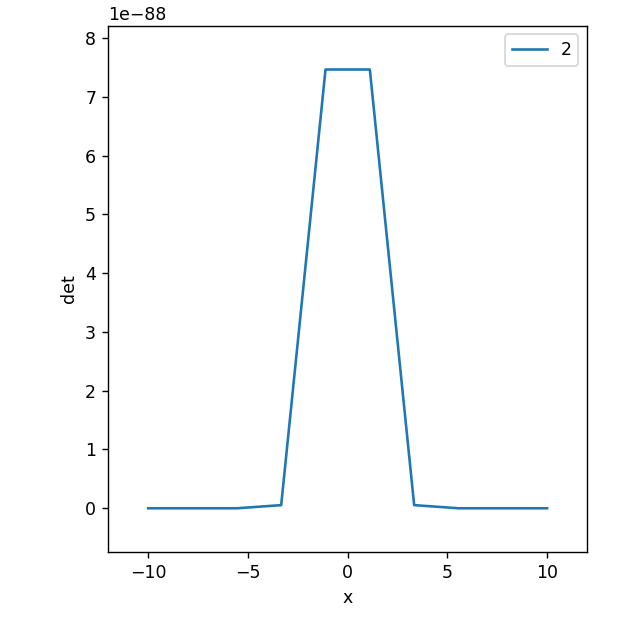

+-----------+------------+------------+------------+
|   seq_num |       time |          x |        det |
+-----------+------------+------------+------------+
|         1 | 15:15:59.7 |    -10.000 |      0.000 |
|         2 | 15:15:59.8 |     -7.778 |      0.000 |
|         3 | 15:15:59.9 |     -5.556 |      0.000 |
|         4 | 15:16:00.0 |     -3.333 |      0.000 |
|         5 | 15:16:00.1 |     -1.111 |      0.000 |
|         6 | 15:16:00.2 |      1.111 |      0.000 |
|         7 | 15:16:00.3 |      3.333 |      0.000 |
|         8 | 15:16:00.4 |      5.556 |      0.000 |
|         9 | 15:16:00.5 |      7.778 |      0.000 |
|        10 | 15:16:00.6 |     10.000 |      0.000 |
+-----------+------------+------------+------------+
generator scan ['0a936300'] (scan num: 2)





('0a936300-0f06-41a2-a47e-22ac46524b5b',)

In [6]:
%matplotlib notebook 

from bluesky.callbacks.best_effort import BestEffortCallback

RE(bp.scan([det], x, -10, 10, 10), BestEffortCallback())

## Custom Plans

- Easy to write your own
- Meant for doing bespoke science



Transient Scan ID: 3     Time: 2022-02-28 15:19:38
Persistent Unique Scan ID: '3fbf1ba2-c787-4957-9e47-e753cbfe207b'
New stream: 'primary'


<IPython.core.display.Javascript object>


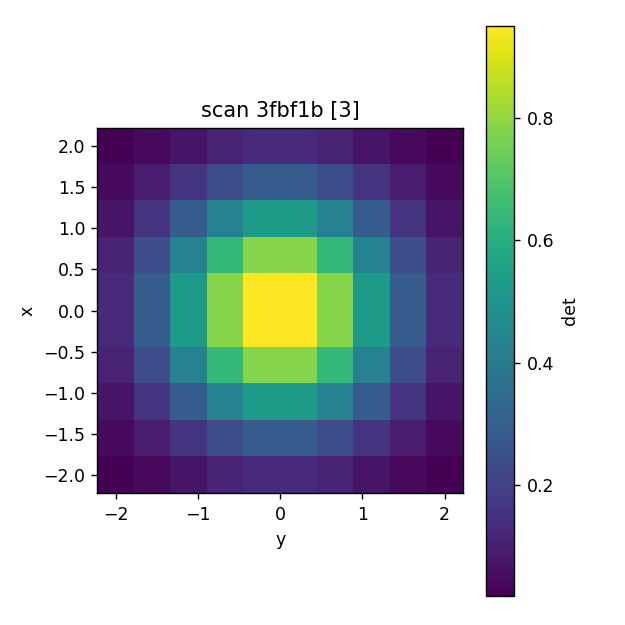

+-----------+------------+------------+------------+------------+
|   seq_num |       time |          x |          y |        det |
+-----------+------------+------------+------------+------------+
|         1 | 15:19:38.6 |     -2.000 |     -2.000 |      0.018 |
|         2 | 15:19:38.7 |     -2.000 |     -1.556 |      0.040 |
|         3 | 15:19:38.9 |     -2.000 |     -1.111 |      0.073 |
|         4 | 15:19:39.0 |     -2.000 |     -0.667 |      0.108 |
|         5 | 15:19:39.1 |     -2.000 |     -0.222 |      0.132 |
|         6 | 15:19:39.2 |     -2.000 |      0.222 |      0.132 |
|         7 | 15:19:39.3 |     -2.000 |      0.667 |      0.108 |
|         8 | 15:19:39.4 |     -2.000 |      1.111 |      0.073 |
|         9 | 15:19:39.5 |     -2.000 |      1.556 |      0.040 |
|        10 | 15:19:39.6 |     -2.000 |      2.000 |      0.018 |
|        11 | 15:19:39.7 |     -1.556 |     -2.000 |      0.040 |
|        12 | 15:19:39.8 |     -1.556 |     -1.556 |      0.089 |
|        1

<IPython.core.display.Javascript object>


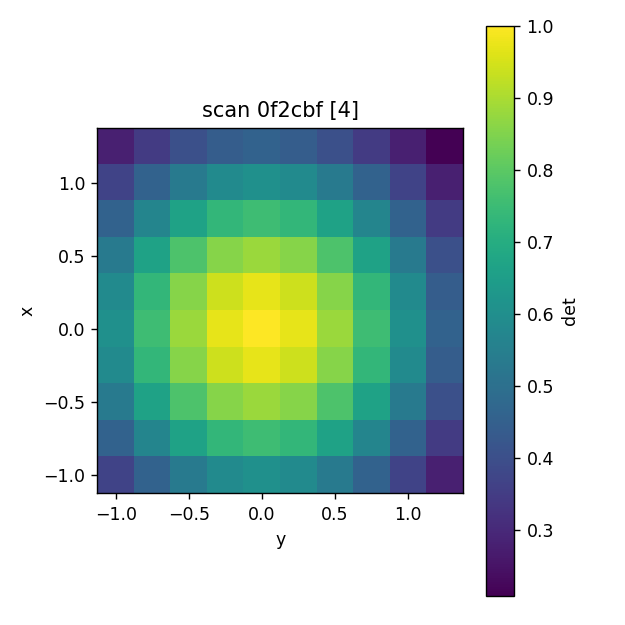

+-----------+------------+------------+------------+------------+
|   seq_num |       time |          x |          y |        det |
+-----------+------------+------------+------------+------------+
|         1 | 15:19:49.3 |     -1.000 |     -1.000 |      0.368 |
|         2 | 15:19:49.5 |     -1.000 |     -0.750 |      0.458 |
|         3 | 15:19:49.6 |     -1.000 |     -0.500 |      0.535 |
|         4 | 15:19:49.7 |     -1.000 |     -0.250 |      0.588 |
|         5 | 15:19:49.8 |     -1.000 |      0.000 |      0.607 |
|         6 | 15:19:49.9 |     -1.000 |      0.250 |      0.588 |
|         7 | 15:19:50.0 |     -1.000 |      0.500 |      0.535 |
|         8 | 15:19:50.1 |     -1.000 |      0.750 |      0.458 |
|         9 | 15:19:50.2 |     -1.000 |      1.000 |      0.368 |
|        10 | 15:19:50.3 |     -1.000 |      1.250 |      0.278 |
|        11 | 15:19:50.4 |     -0.750 |     -1.000 |      0.458 |
|        12 | 15:19:50.5 |     -0.750 |     -0.750 |      0.570 |
|        1

('3fbf1ba2-c787-4957-9e47-e753cbfe207b',
 '0f2cbf18-e20b-45f2-a13d-83e13de9ef2d')

In [7]:
def zoom_in(start_x: float, start_y: float, stop_x: float, stop_y: float, res: int):
    # Scan given area
    yield from bp.grid_scan([det], x, start_x, stop_x, res, y, start_y, stop_y, res)
    
    # Zoomed-in version
    start_x += (stop_x - start_x) / 4
    start_y += (stop_y - start_y) / 4
    stop_x -= (stop_x - start_x) / 4
    stop_y -= (stop_y - start_y) / 4
    yield from bp.grid_scan([det], x, start_x, stop_x, res, y, start_y, stop_y, res)

RE(zoom_in(-2, -2, 2, 2, 10), BestEffortCallback())

## Adaptive Plans and Automation

- Plans can be made to react to measurement results or changes in environment
- Potential use for creating complicated, bespoke workflows
- Interesting potential for beamline automation
- MX particularly interested in this

https://github.com/DiamondLightSource/python-artemis


In [9]:
import time
from math import sin
from ophyd.sim import SynPeriodicSignal

# Create simulated temperature readout
def sine_temp() -> float:
    return sin(time.time()) * 10 + 15

temperature = SynPeriodicSignal(sine_temp, name="temperature")
temperature.start_simulation()

<IPython.core.display.Javascript object>


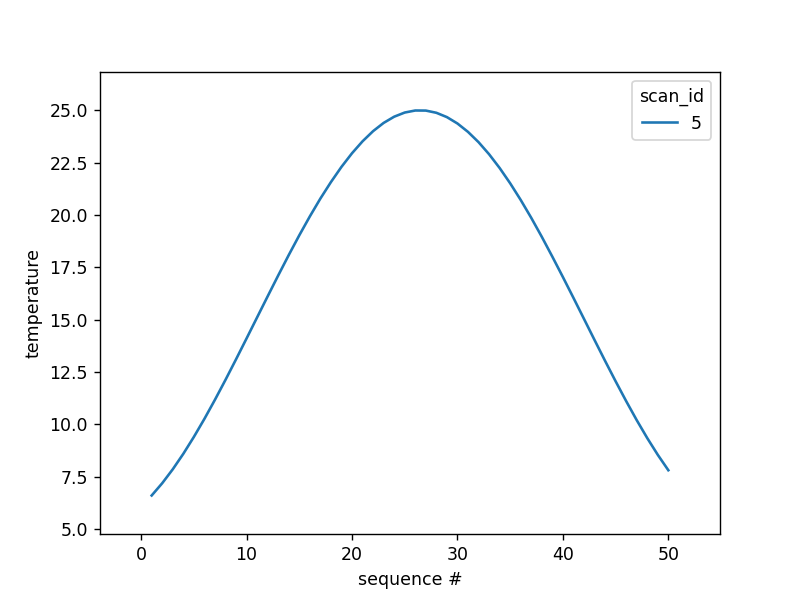

('b5ef2205-4673-477c-bc9b-b6e2c00cfc17',)

In [10]:
from bluesky.callbacks import LivePlot

RE(bp.count([temperature], num=50, delay=0.1), LivePlot("temperature"))

In [11]:
from typing import List
from dataclasses import dataclass

from bluesky.preprocessors import monitor_during_decorator, suspend_decorator
from bluesky.suspenders import SuspendWhenOutsideBand

@dataclass
class Instruction:
    start: float
    stop: float
    steps: int

def my_experiment(scans_to_do: List[Instruction], min_temp: float, max_temp: float):
    suspender = SuspendWhenOutsideBand(temperature, min_temp, max_temp)

    @suspend_decorator([suspender])
    @monitor_during_decorator([temperature])
    def do_scans():
        for instruction in scans_to_do:
            yield from bp.scan([det], x, instruction.start, instruction.stop, instruction.steps)

    return (yield from do_scans())


Subscription value callback exception (SynPeriodicSignal(name='temperature', value=24.24356180843659, timestamp=1646063302.2025397))
Traceback (most recent call last):
  File "/home/vid18871/projects/presentations/bluesky-basics/venv/lib/python3.8/site-packages/ophyd/ophydobj.py", line 462, in inner
    cb(*args, **kwargs)
  File "/home/vid18871/projects/presentations/bluesky-basics/venv/lib/python3.8/site-packages/bluesky/suspenders.py", line 145, in __call__
    raise RuntimeError("Could not create the ")
RuntimeError: Could not create the 


<IPython.core.display.Javascript object>


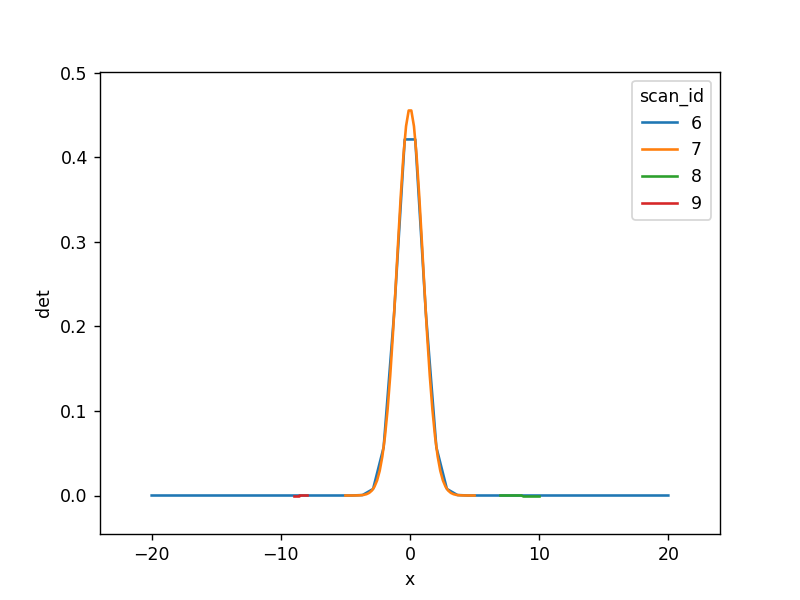

Suspending....To get prompt hit Ctrl-C twice to pause.
Suspension occurred at 2022-02-28 15:48:24.
Justification for this suspension:
Signal temperature = 9.955587011311488 is outside of the range (10.0, 22.0)
Suspender SuspendWhenOutsideBand(SynPeriodicSignal(name='temperature', value=14.023597982275138, timestamp=1646063307.2086005), sleep=0, pre_plan=None, post_plan=None,tripped_message=) reports a return to nominal conditions. Will sleep for 0 seconds and then release suspension at 2022-02-28 15:48:27.
Suspending....To get prompt hit Ctrl-C twice to pause.
Suspension occurred at 2022-02-28 15:48:28.
Justification for this suspension:
Signal temperature = 23.33352927967597 is outside of the range (10.0, 22.0)
Suspender SuspendWhenOutsideBand(SynPeriodicSignal(name='temperature', value=21.54843159107153, timestamp=1646063314.303539), sleep=0, pre_plan=None, post_plan=None,tripped_message=) reports a return to nominal conditions. Will sleep for 0 seconds and then release suspension at

('6839130c-6667-4041-89f0-4c3f683de13a',
 'ef387d6b-5c77-4476-9a99-f16b49b9cad7',
 '2b5b62b4-222b-40a1-b65e-e4f880cdb004',
 '62a9a9a4-d735-4484-9d0d-f9437b7a756b')

In [12]:
scans = [
    Instruction(-20., 20., 50),
    Instruction(-5., 5., 50),
    Instruction(7., 10., 20),
    Instruction(-9., -8., 20),
]

RE(my_experiment(scans, 10., 22.), LivePlot("det", "x"))

## Comparison with Diamond's Data Collection System

- GDA
- Java application with a Jython interpreter for scripting
- GUIs
- Scannables and detectors

## Why are we Interested in Bluesky?

- Jython no longer supported
- Restricted to Python 2
- Hard to maintain a hybrid application, may be better to have a clean cut between Java and Python code
- Hardware triggered scanning

## Bluesky-as-a-Service

- Controlled via REST API/GraphQL API/Message Bus
- Takes commands and emits events
- Easy to add new plans

<img src="img/service.svg" width="500"/>

Would like to be able to write

```python
def my_special_plan(detectors: List[Readable], motor: Movable, number_of_iterations: int = 3):
    ...
```

And have it automatically converted to an endpoint

#### Prototyping Work
- NSLS-II: https://github.com/bluesky/bluesky-queueserver
- DLS: https://gitlab.diamond.ac.uk/daq/d2acq/services/bluesky-service

## Ophyd V2

- https://github.com/dls-controls/ophyd
- Early stages of development
- Support for Malcolm-style hardware triggered scanning through the `Flyable` interface
- Numerous architectural imrpovements
